In [ ]:
!pip install -U fastai

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print(os.listdir("/content/drive/My Drive/"))

['Colab Notebooks', 'AlzheimersDataset', 'skin_cancer', 'Kaggle_Skin_Cancer', 'Dataset']


In [5]:
path = Path("/content/drive/My Drive/Dataset/")
model_path = Path(path/'models')
train_path = Path(path/'train')
path.ls()

(#34) [Path('/content/drive/My Drive/Dataset/test'),Path('/content/drive/My Drive/Dataset/valid'),Path('/content/drive/My Drive/Dataset/train'),Path('/content/drive/My Drive/Dataset/models'),Path('/content/drive/My Drive/Dataset/test_result_resnet50.csv'),Path('/content/drive/My Drive/Dataset/val_result_resnet50.csv'),Path('/content/drive/My Drive/Dataset/val_result_effnetB0.csv'),Path('/content/drive/My Drive/Dataset/test_result_effnetB0.csv'),Path('/content/drive/My Drive/Dataset/deployment'),Path('/content/drive/My Drive/Dataset/val_result_resnext101.csv')...]

# Data Loading

In [6]:
def get_data(img_size, bs):
  item_tfms = RandomResizedCrop(480, min_scale=0.80)
  batch_tfms = [*aug_transforms(size=img_size, max_rotate=20, flip_vert=True), Normalize()]

  data = ImageDataLoaders.from_folder(path, train='train', valid='valid', 
                                      bs=bs, item_tfms=item_tfms, batch_tfms=batch_tfms)
  return data

In [ ]:
bs = 32
img_size = 128
data = get_data(img_size, bs)

# Squeezenet1_1

## Training on low-resolution images 

In [ ]:
squeezenet1_model = cnn_learner(data, squeezenet1_1, opt_func=ranger, metrics=accuracy, model_dir=model_path, cbs=[ShowGraphCallback]).to_fp16()

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth


In [ ]:
squeezenet1_model.summary() 

Sequential (Input shape: ['32 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 63 x 63    1,792      False     
________________________________________________________________
ReLU                 32 x 64 x 63 x 63    0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 31 x 31    0          False     
________________________________________________________________
Conv2d               32 x 16 x 31 x 31    1,040      False     
________________________________________________________________
ReLU                 32 x 16 x 31 x 31    0          False     
________________________________________________________________
Conv2d               32 x 64 x 31 x 31    1,088      False     
________________________________________________________________
ReLU                 32 x 64 x 31 x 31    0          False     
_________________________________________________

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.0003162277629598975, lr_steep=3.981071756697929e-07)

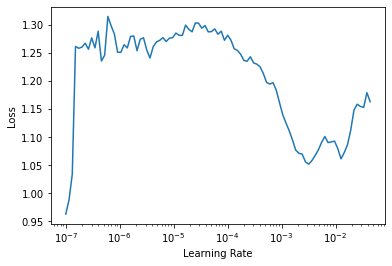

In [ ]:
squeezenet1_model.lr_find(end_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.823535,0.502920,0.792929,01:08


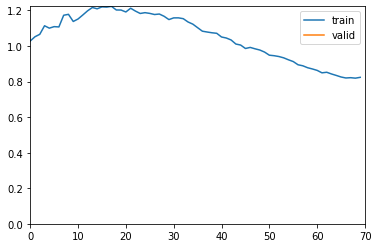

epoch,train_loss,valid_loss,accuracy,time
0,0.667663,0.480586,0.797980,00:22
1,0.587213,0.443665,0.803030,00:22
2,0.579254,0.425266,0.810606,00:22
3,0.552505,0.396364,0.825758,00:22
4,0.481193,0.377317,0.838384,00:22
5,0.455207,0.361681,0.823232,00:22
6,0.418071,0.348580,0.848485,00:22
7,0.448441,0.353617,0.835859,00:22
8,0.405604,0.354938,0.835859,00:22
9,0.415307,0.358660,0.833333,00:22


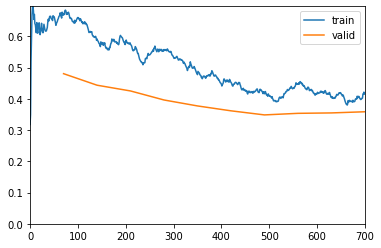

In [ ]:
squeezenet1_model.fine_tune(10, 1e-3)

In [ ]:
squeezenet1_model.save('Squeezenet1_128_01')

Path('/content/drive/My Drive/Dataset/models/Squeezenet1_128_01.pth')

## Progressive Resizing 
image_size = 224

In [ ]:
squeezenet1_model = None
data = None
torch.cuda.empty_cache()

In [ ]:
data = get_data(224, 32)  

In [ ]:
squeezenet1_model = cnn_learner(data, squeezenet1_1, opt_func=ranger, cbs=[ShowGraphCallback], 
                                model_dir=model_path, metrics = [accuracy]).to_fp16()
squeezenet1_model.load('Squeezenet1_128_01')
squeezenet1_model.freeze()

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=4.365158383734524e-05)

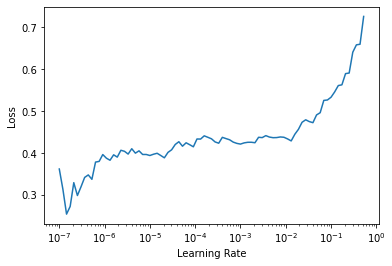

In [ ]:
squeezenet1_model.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.484492,0.336980,0.825758,04:29


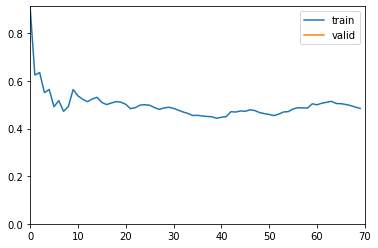

epoch,train_loss,valid_loss,accuracy,time
0,0.436579,0.325391,0.840909,00:20
1,0.442810,0.336993,0.845960,00:20
2,0.404522,0.312767,0.861111,00:20
3,0.376877,0.320445,0.851010,00:20
4,0.367907,0.328336,0.840909,00:20
5,0.354551,0.369126,0.823232,00:20
6,0.329934,0.329920,0.828283,00:21
7,0.314451,0.314844,0.853535,00:21
8,0.287620,0.300555,0.871212,00:20
9,0.274870,0.292084,0.861111,00:20


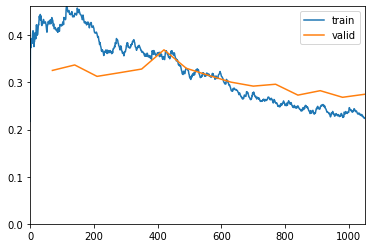

In [ ]:
squeezenet1_model.fine_tune(15, wd=0.01)

In [ ]:
squeezenet1_model.save('squeezenet1_model_224_01')

Path('/content/drive/My Drive/Dataset/models/squeezenet1_model_224_01.pth')

## Observe missclassified images

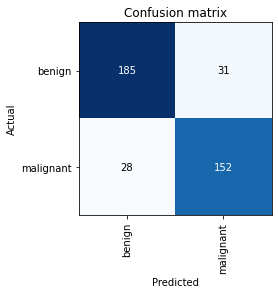

In [ ]:
interp = ClassificationInterpretation.from_learner(squeezenet1_model.to_fp16())
interp.plot_confusion_matrix();

In [ ]:
interp.print_classification_report()

              precision    recall  f1-score   support

      benign       0.87      0.86      0.86       216
   malignant       0.83      0.84      0.84       180

    accuracy                           0.85       396
   macro avg       0.85      0.85      0.85       396
weighted avg       0.85      0.85      0.85       396



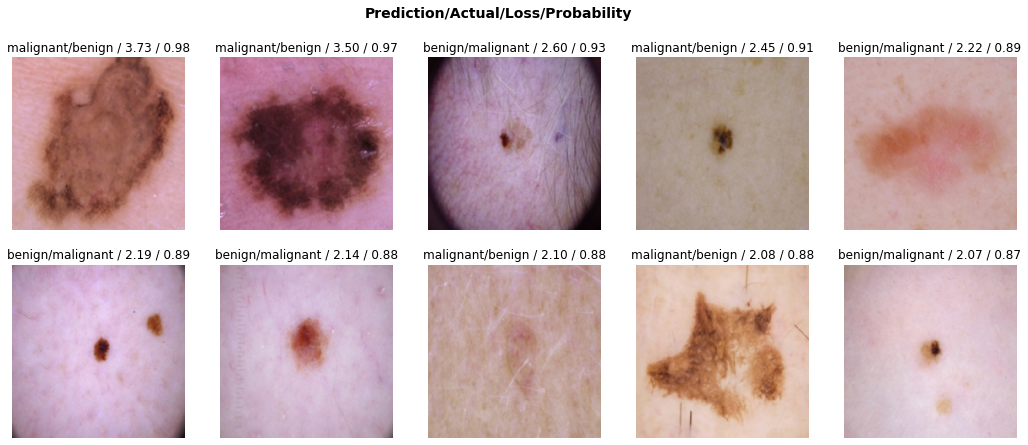

In [ ]:
interp.plot_top_losses(10, nrows=2, ncols=5, figsize=(18,7))

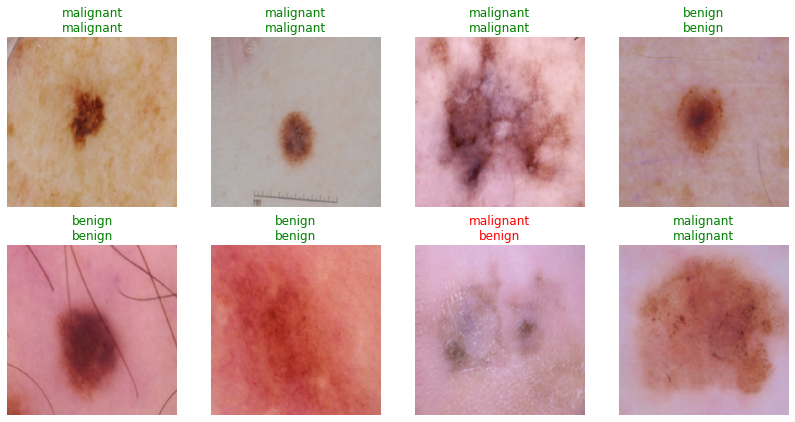

In [ ]:
squeezenet1_model.show_results(max_n=8, nrows=2, ncols=4, figsize=(14,7))

# Evaluation on Testing data

In [7]:
data = get_data(224, 32)
squeezenet1_model = cnn_learner(data, squeezenet1_1, opt_func=ranger, cbs=[ShowGraphCallback], 
                             model_dir=model_path, metrics = [accuracy]).to_fp16()
squeezenet1_model.load('squeezenet1_model_224_01')


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth


In [8]:
test_path = Path(path/'test')
tst_fns = get_image_files(test_path)
# split label from Parent Folder
tst_lbl = [parent_label(fn) for fn in tst_fns]
dl = squeezenet1_model.dls.test_dl(tst_fns, with_labels=True)

tst_lbl_num = [0 if lbl == 'benign' else 1 for lbl in tst_lbl]
tst_lbl_num[:10], tst_lbl_num[-10:]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

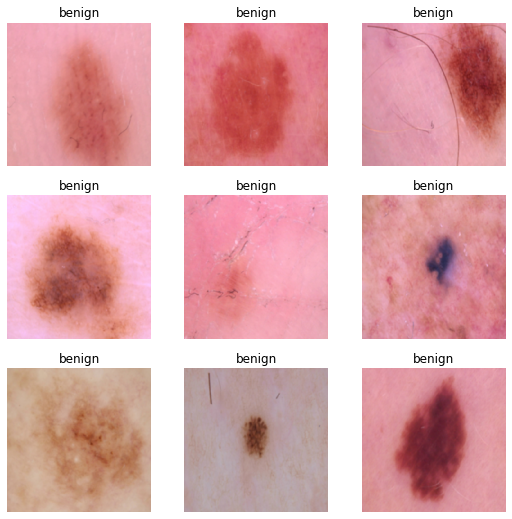

In [ ]:
dl.show_batch()

In [ ]:
# Using Test Time Augmentation Technique
#preds, _ = squeezenet1_model.tta(dl=dl)

In [9]:
# Normal Prediction (without augmentation on the testing set)
preds, _ = squeezenet1_model.get_preds(dl=dl)

In [10]:
preds_num = preds.argmax(1)
preds_num[:10], preds_num[-10:]

(TensorImage([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 TensorImage([0, 0, 0, 1, 0, 0, 0, 1, 0, 0]))

In [11]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

In [12]:
accuracy_score(tst_lbl_num, preds_num)

0.8742424242424243

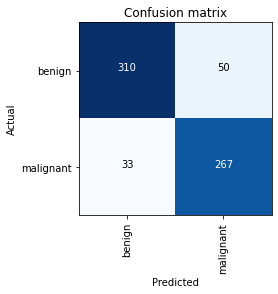

In [13]:
cm = confusion_matrix(tst_lbl_num, preds_num)
plot_confusion_matrix(cm, data.vocab)

In [14]:
print(classification_report(tst_lbl_num, preds_num))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       360
           1       0.84      0.89      0.87       300

    accuracy                           0.87       660
   macro avg       0.87      0.88      0.87       660
weighted avg       0.88      0.87      0.87       660



# Save Prediction

In [15]:
def get_model_prob_csv(model, dls, model_name):
  if dls == 'valid':
    val_path = Path(path/'valid')
    val_fns = get_image_files(val_path)
    val_lbl = [parent_label(fn) for fn in val_fns]
    Y_val = [0 if lbl == 'benign' else 1 for lbl in val_lbl]
    prob, _ = model.get_preds(dl=model.dls.valid)
    #Save Prediction in csv file
    df = pd.DataFrame({'val_prob': np.array(prob[:,1]), 
                       'pred_y': np.array(prob.argmax(1)),'y': Y_val})
    df.to_csv(path/"val_result_{}.csv".format(model_name), index=False)
    print('Validation dataframe created ...')

  elif dls == 'test':
    test_path = Path(path/'test')
    tst_fns = get_image_files(test_path)
    tst_lbl = [parent_label(fn) for fn in tst_fns]
    Y_test = [0 if lbl == 'benign' else 1 for lbl in tst_lbl]
    dl = model.dls.test_dl(tst_fns, with_labels=True)
    prob, _ = model.get_preds(dl=dl)
    #Save Prediction in csv file
    df = pd.DataFrame({'tet_prob': np.array(prob[:,1]), 
                       'pred_y': np.array(prob.argmax(1)), 'y': Y_test})
    df.to_csv(path/"test_result_{}.csv".format(model_name) , index=False)
    print('Test dataframe created ...')


In [16]:
get_model_prob_csv(model=squeezenet1_model, dls='valid', model_name='squeezenet1_1_notta')
get_model_prob_csv(model=squeezenet1_model, dls='test', model_name='squeezenet1_1_notta')

Validation dataframe created ...


Test dataframe created ...


In [17]:
## Download the csv files
valid_df = pd.read_csv(path/'val_result_squeezenet1_1_notta.csv')
test_df = pd.read_csv(path/'test_result_squeezenet1_1_notta.csv')

In [18]:
valid_df.head()

,val_prob,pred_y,y
0,0.999910,1,1
1,0.981453,1,1
2,0.541651,1,1
3,0.071591,0,1
4,0.953751,1,1


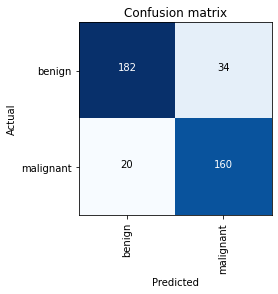

0.8636363636363636

In [19]:
cm = confusion_matrix(valid_df.y, valid_df.pred_y)
plot_confusion_matrix(cm, ['benign','malignant'])
accuracy_score(valid_df.y, valid_df.pred_y)

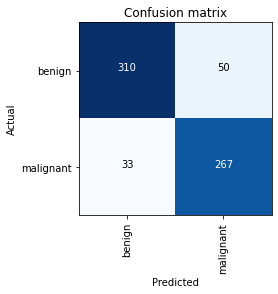

0.8742424242424243

In [20]:
cm = confusion_matrix(test_df.y, test_df.pred_y)
plot_confusion_matrix(cm, ['benign','malignant'])
accuracy_score(test_df.y, test_df.pred_y)

In [21]:
print(classification_report(test_df.y, test_df.pred_y))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       360
           1       0.84      0.89      0.87       300

    accuracy                           0.87       660
   macro avg       0.87      0.88      0.87       660
weighted avg       0.88      0.87      0.87       660



# Export model

In [ ]:
squeezenet1_model.export('squeezenet1_1.pkl') 
path.ls(file_exts='.pkl') # check if the saved model is in the path

(#1) [Path('/content/drive/My Drive/Dataset/squeezenet1_1.pkl')]